# QC Report for Methylation Calling

This notebook generates a comprehensive quality control report for methylation analysis using MethylDackel output data.

In [27]:
# Import required modules
import warnings

import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from ugbio_methylation.qc_report_generator import MethylationQCReportGenerator, ReportConfig

# Configure notebook settings
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 10000)
pd.set_option("display.width", 1200)
pd.set_option("display.max_colwidth", 0)

In [ ]:
# Configuration - these parameters are injected during report generation
input_h5_file = ""
input_base_file_name = ""

In [29]:
# Initialize the report generator
config = ReportConfig(input_h5_file=input_h5_file, input_base_file_name=input_base_file_name)

report_generator = MethylationQCReportGenerator(config)

## Input Parameters

In [30]:
report_generator.display_sample_info()

,value
Sample name,test
h5 file,/home/ubuntu/ugbio- utils/src/methylation/tests/resources/concat_methyldackel_csvs.methyl_seq.applicationQC.h5


## Human Genome: Global Methylation Statistics

In [31]:
report_generator.generate_global_stats()

,value
metric,
Percent Methylation: mean,75.69
Percent Methylation: std,26.33
Percent Methylation: median,85.00
Total CpGs:,"4,999"
Coverage: mean,37.62
Coverage: std,57.50
Coverage: median,25.00


## Human Genome: Details of Per-Read Descriptive Statistics

In [32]:
report_generator.generate_per_read_stats()

,value
metric,
Percent Methylation: mean,44.45
Percent Methylation: std,44.02
Percent Methylation: median,33.33
Total CpGs: mean,5.92
Total CpGs: std,9.13
Total CpGs: median,2.00


## Human Genome: Cytosines in Other Contexts Descriptive Statistics

In [33]:
report_generator.generate_non_cpg_stats()

,value
metric,
Percent Methylation: Mean,1.80%
Percent Methylation: Std,10.82%
Percent Methylation: Median,0.00%
Coverage: Mean,4.72
Coverage: Std,3.61
Coverage: Median,4.00
,value
metric,
Percent Methylation: Mean,2.68%


## Human Genome: M-bias plots of mean methylation along reads

,value
metric,
Percent Methylation: Mean,48.14%
Percent Methylation: Std,10.81%
Percent Methylation: Median,52.28%
,value
metric,
Percent Methylation: Mean,47.65%
Percent Methylation: Std,13.53%
Percent Methylation: Median,53.98%


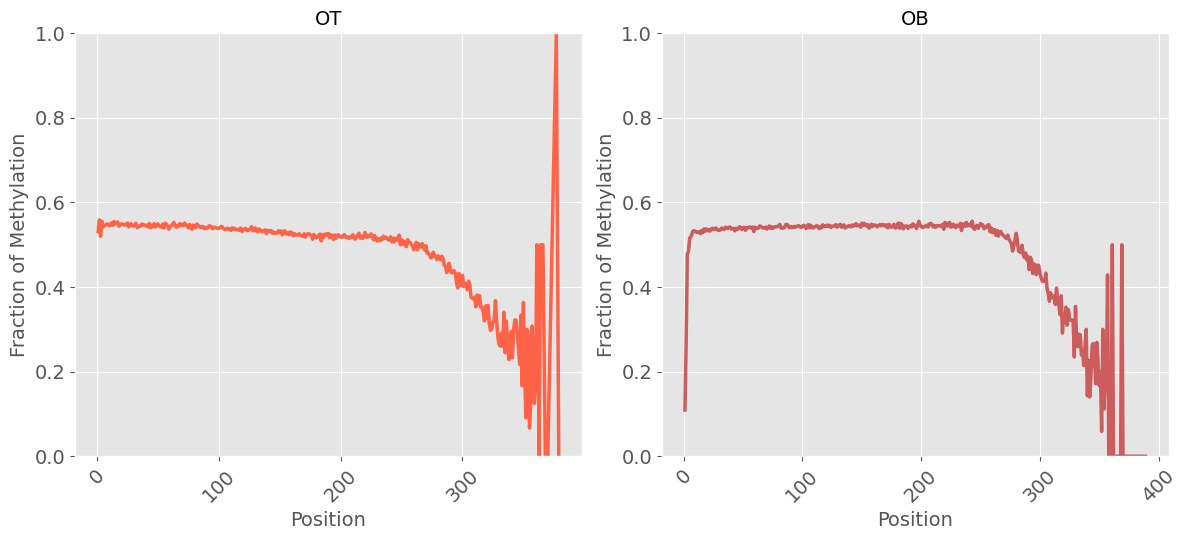

In [34]:
report_generator.generate_mbias_analysis()

## Human Genome: M-bias plots of mean methylation on CHH/CHG along reads

,value
metric,
Percent Methylation: Mean,1.35%
Percent Methylation: Std,0.62%
Percent Methylation: Median,1.35%
,value
metric,
Percent Methylation: Mean,1.40%
Percent Methylation: Std,0.78%
Percent Methylation: Median,1.44%


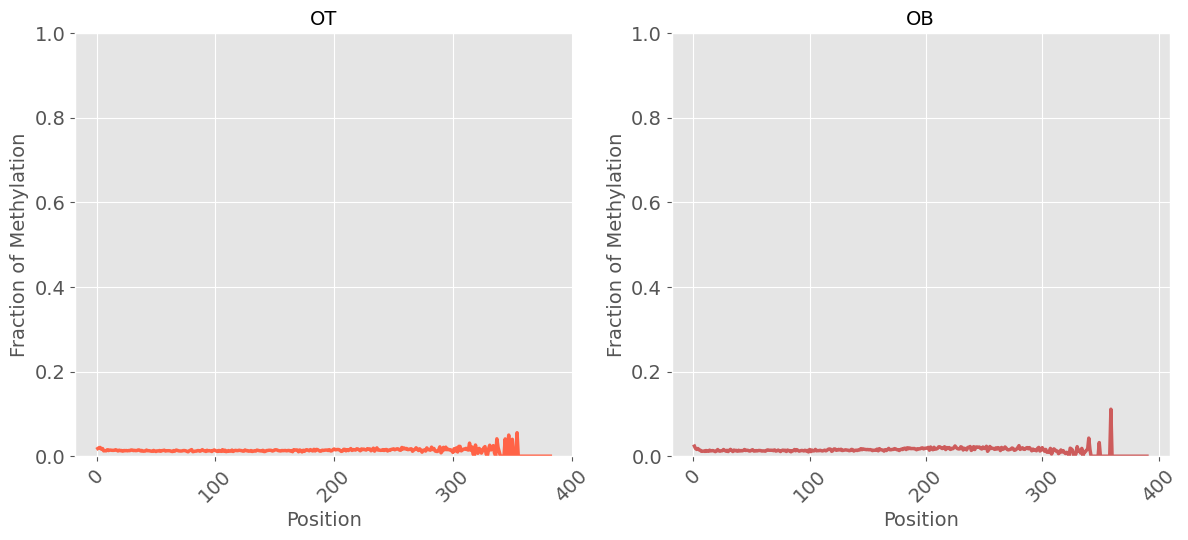

In [35]:
report_generator.generate_mbias_non_cpg_analysis()

## Control Genomes Analysis

,value
metric,
Percent Methylation: Mean,0.12%
Percent Methylation: Std,1.06%
Percent Methylation: Median,0.00%
Total CpGs:,"3,113"
Coverage: Mean,693.90
Coverage: Std,159.15
Coverage: Median,723.00
,value
metric,


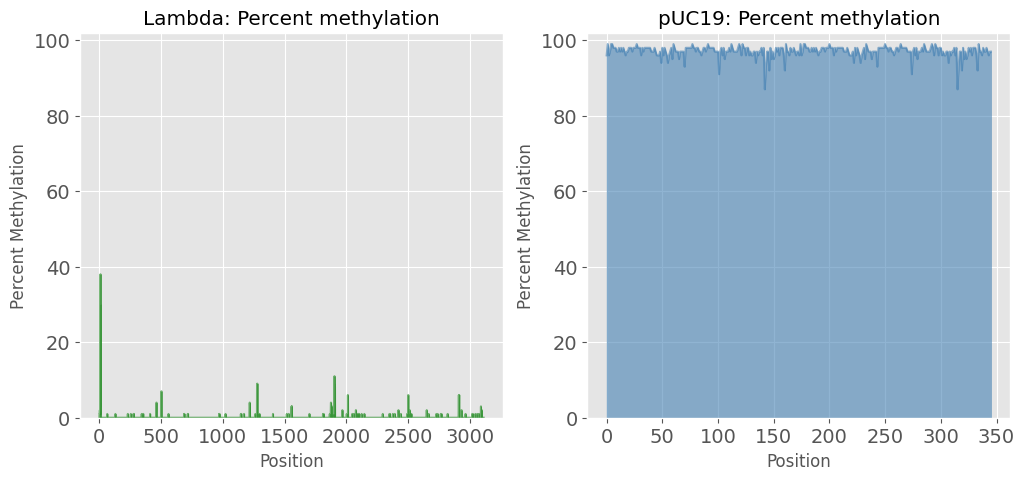

In [36]:
report_generator.generate_control_genome_analysis()

## Human Genome: Additional Details of CpG Methylation and Coverage

,value
bin,
10,264
20,45
30,99
40,132
50,126
60,331
70,429
80,572
90,"1,017"


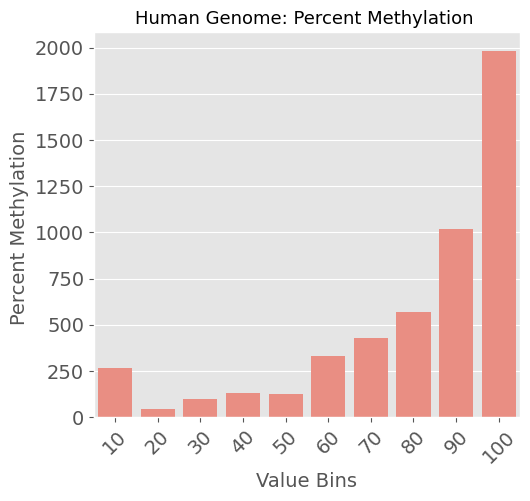

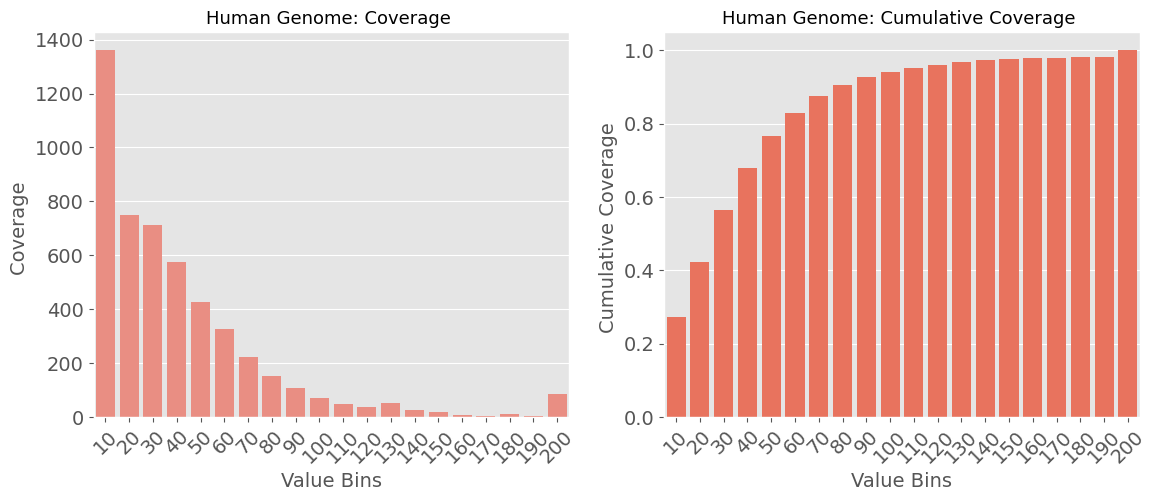

In [37]:
report_generator.generate_histogram_analysis()